# Gradient Descent Methods

The aim of this material is to code 
- coordinate gradient descent (CD)
- gradient descent (GD)
- stochastic gradient descent (SGD)
- accelerated gradient descent (AGD)
- stochastic variance reduced gradient descent (SVRG)
- newton descent

and apply them on the linear regression and logistic regression models, with ridge penalization.

In [1]:
print('\n\n(If this cell runs for more than 30 seconds, stop it and rerun it.) \n\n')


import requests
exec(requests.get("https://raw.githubusercontent.com/claireBoyer/tutorial-conformal-prediction/main/labs/aux-npt/get-send-code.html").content)


# Replace 'TO_UPDATE' with the appropriate session information
npt_config = {'session_name': 'Lab4-Map545',}


# Prompt for the sender's name
npt_config['sender_name'] = input("Enter your name: \n -->")
npt_config['session_owner'] = input("\n \n Your teacher: depending on your teacher, enter either \n - ataylor \n - pascalbianchi \n - constantin.philippenko \n - renaud.gaucher \n-->") #  

print('\n \n You should get as an output <Response [200]> below. If not, you probably have a typo in the teacher name, retry :)')

send('started', 0)



(If this cell runs for more than 30 seconds, stop it and rerun it.) 


Enter your name: 
 -->

 
 Your teacher: depending on your teacher, enter either 
 - ataylor 
 - pascalbianchi 
 - constantin.philippenko 
 - renaud.gaucher 
-->

 
 You should get as an output <Response [200]> below. If not, you probably have a typo in the teacher name, retry :)


<Response [400]>

# Table of content

[1. Introduction](#intro)<br>

[2. Models gradients and losses](#models)<br>

[2.1  Linear regression](#models_regression)<br>
[2.2  Check for Linear regression](#models_regression_check)<br>
[2.3  Logistic regression](#models_logistic)<br>
[2.4  Check for logistic regression](#models_logistic_check)<br>


[3. Solvers](#solvers)<br>

[3.1 Tools for solvers](#tools)<br>
[3.2 Gradient descent](#gd)<br>
[3.3 Stochastic Gradient descent](#sgd)<br>
[3.4 Accelerated Gradient descent](#agd)<br>
[3.5 Heavy ball method](#hb)<br>
[3.6 Stochastic Average Gradient descent](#sag)<br>
[3.7 Stochastic Variance Reduced Gradient descent](#svrg)<br>
[3.8 Newton descent](#newton)<br>
[3.9 Coordinate Gradient descent](#cgd)<br>
[3.10 Comparison of all previous algorithms](#comparison)<br>

[4. Bonus](#bonus)<br>
[4.1 Compare algorithmic complexity and time](#bonus_complexity)<br>


<a id='intro'></a>
# 1. Introduction

## 1.1. Getting model weights

We'll start by generating sparse vectors and simulating data

In [2]:
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

np.set_printoptions(precision=2) # to have simpler print outputs with numpy

## 1.2. Simulation of a linear model

In [3]:
from numpy.random import randn
from numpy.random import multivariate_normal
from scipy.linalg import toeplitz

In [4]:
def simu_linreg(w0, n_samples=1000, corr=0.5, std=0.5):
    """Simulation of a linear regression model with Gaussian features
    and a Toeplitz covariance, with Gaussian noise.
    
    Parameters
    ----------
    w0 : `numpy.array`, shape=(n_features,)
        Model weights
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features
    
    std : `float`, default=0.5
        Standard deviation of the noise
    
    Returns
    -------
    X : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It contains samples of a centered 
        Gaussian  vector with Toeplitz covariance.
    
    y : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    n_features = w0.shape[0]
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    X = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    y = X.dot(w0) + std * randn(n_samples)
    return X, y

<Response [400]>

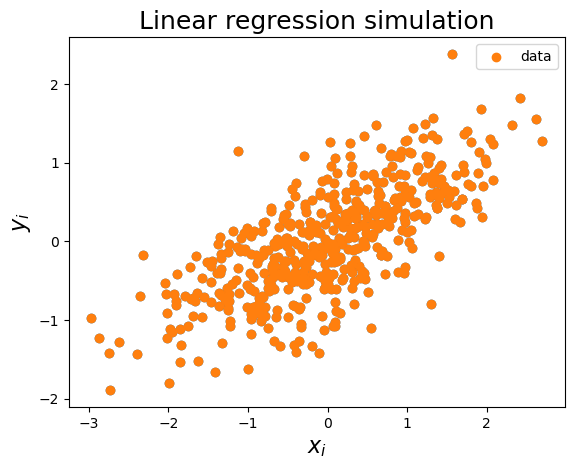

In [5]:
n_samples = 500
w0 = np.array([0.5])

X, y = simu_linreg(w0, n_samples=n_samples, corr=0.3, std=0.5)
plt.scatter(X, y)
plt.xlabel(r"$x_i$", fontsize=16)
plt.ylabel(r"$y_i$", fontsize=16)
plt.title("Linear regression simulation", fontsize=18)
plt.scatter(X, y, label='data')
plt.legend()
send(plt, 1)

## 1.3. Simulation of a logistic regression model

In [6]:
def sigmoid(t):
    """Sigmoid function (overflow-proof)"""
    idx = t > 0
    out = np.empty(t.size)    
    out[idx] = 1 / (1. + np.exp(-t[idx]))
    exp_t = np.exp(t[~idx])
    out[~idx] = exp_t / (1. + exp_t)
    return out

def simu_logreg(w0, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model with Gaussian features
    and a Toeplitz covariance.
    
    Parameters
    ----------
    w0 : `numpy.array`, shape=(n_features,)
        Model weights
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    X : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It contains samples of a centered 
        Gaussian vector with Toeplitz covariance.
    
    y : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    n_features = w0.shape[0]
    cov = toeplitz(corr ** np.arange(0, n_features))
    X = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(X.dot(w0))
    y = np.random.binomial(1, p, size=n_samples)
    # Put the label in {-1, 1}
    y[:] = 2 * y - 1
    return X, y

<Response [400]>

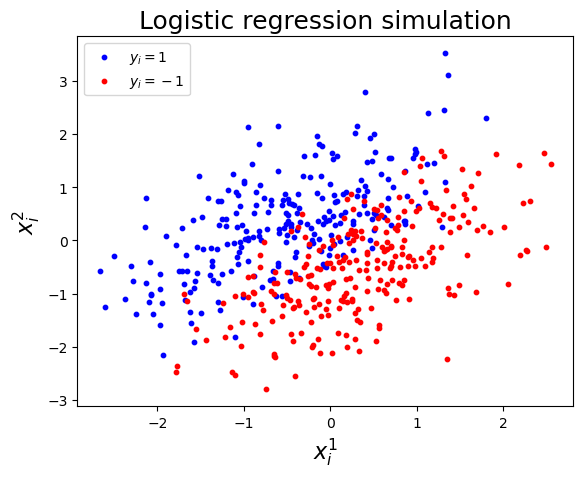

In [7]:
n_samples = 500
w0 = np.array([-3, 3.])

X, y = simu_logreg(w0, n_samples=n_samples, corr=.4)

plt.scatter(*X[y == 1].T, color='b', s=10, label=r'$y_i=1$')
plt.scatter(*X[y == -1].T, color='r', s=10, label=r'$y_i=-1$')
plt.legend(loc='upper left')
plt.xlabel(r"$x_i^1$", fontsize=16)
plt.ylabel(r"$x_i^2$", fontsize=16)
plt.title("Logistic regression simulation", fontsize=18)
send(plt, 2)

<a id='models'></a>
# 2. Models gradients and losses

We want to minimize a goodness-of-fit function $f$ with ridge regularization, namely
$$
\arg\min_{w \in \mathbb R^d} \Big\{ f(w) + \frac{\lambda}{2} \|w\|_2^2 \Big\}
$$
where $d$ is the number of features and where we will assume that $f$ is $L$-smooth.
We will consider below the following cases.

**Linear regression**, where 
$$
f(w) = \frac 1n \sum_{i=1}^n f_i(w) = \frac{1}{2n} \sum_{i=1}^n (y_i - x_i^\top w)^2 + \frac{\lambda}{2} \|w\|_2^2 = \frac{1}{2 n} \| y - X w \|_2^2 + \frac{\lambda}{2} \|w\|_2^2,
$$
where $n$ is the sample size, $y = [y_1 \cdots y_n]$ is the vector of labels and $X$ is the matrix of features with lines containing the features vectors $x_i \in \mathbb R^d$.

**Logistic regression**, where
$$
f(w) = \frac 1n \sum_{i=1}^n f_i(w) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-y_i x_i^\top w)) + \frac{\lambda}{2} \|w\|_2^2,
$$
where $n$ is the sample size, and where labels $y_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f(w)$ and its gradient $\nabla f(w)$, in order to solve this problem, as well as $\nabla f_i(w)$ for stochastic gradient descent methods and $\frac{\partial f(w)}{\partial w_j}$ for coordinate descent.

Below is the full implementation for linear regression.

<a id='models_regression'></a>

## 2.1 Linear regression

In [8]:
from numpy.linalg import norm


class ModelLinReg:
    """A class giving first order information for linear regression
    with least-squares loss
    
    Parameters
    ----------
    X : `numpy.array`, shape=(n_samples, n_features)
        The features matrix
    
    y : `numpy.array`, shape=(n_samples,)
        The vector of labels
    
    strength : `float`
        The strength of ridge penalization
    """    
    def __init__(self, X, y, strength):
        self.X = X
        self.y = y
        self.strength = strength
        self.n_samples, self.n_features = X.shape
    
    def loss(self, w):
        """Computes f(w)"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        return 1 / 2 * norm(y - X.dot(w)) ** 2 / n_samples + strength * norm(w) ** 2 / 2
    
    def grad(self, w):
        """Computes the gradient of f at w"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        return X.T.dot(X.dot(w) - y) / n_samples + strength * w

    def grad_i(self, i, w):
        """Computes the gradient of f_i at w"""
        x_i = self.X[i]
        return (x_i.dot(w) - y[i]) * x_i + self.strength * w

    def grad_coordinate(self, j, w):
        """Computes the partial derivative of f with respect to 
        the j-th coordinate"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        return X[:, j].T.dot(X.dot(w) - y) / n_samples + strength * w[j]
    
    def hessian(self):
        X, n_samples, n_features = self.X, self.n_samples, self.n_features
        return(X.T.dot(X))/ n_samples + self.strength * np.eye(n_features)

    def lip(self):
        """Computes the Lipschitz constant of the gradients of  f"""
        H = self.hessian()
        return norm(H, 2)

    def lip_coordinates(self):
        """Computes the Lipschitz constant of the gradients of f with respect to 
        the j-th coordinate"""
        X, n_samples = self.X, self.n_samples
        return (X ** 2).sum(axis=0) / n_samples + self.strength
        
    def lip_max(self):
        """Computes the maximum of the lipschitz constants of the gradients of f_i"""
        X, n_samples = self.X, self.n_samples
        return ((X ** 2).sum(axis=1) + self.strength).max()
    
    

<a id='models_regression_check'></a>

## 2.2 Checks for the linear regression model

Text(0.5, 1.0, 'Model weights')

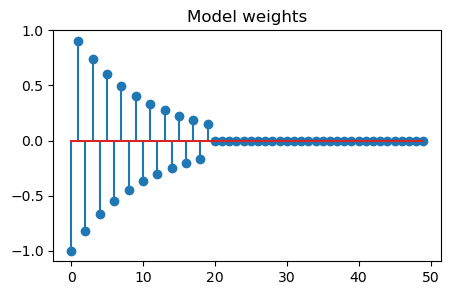

In [9]:
## Simulation setting
n_features = 50
nnz = 20
idx = np.arange(n_features)
w0 = (-1) ** (idx + 1) * np.exp(-idx / 10.)
w0[nnz:] = 0.

plt.figure(figsize=(5, 3))
plt.stem(w0)
plt.title("Model weights")

In [10]:
from scipy.optimize import check_grad

X, y = simu_linreg(w0, corr=0.6)
model = ModelLinReg(X, y, strength=1e-3)
w = np.random.randn(n_features)

send(float(check_grad(model.loss, model.grad, w)), 3)
print(check_grad(model.loss, model.grad, w)) # This must be a number (of order 1e-6)

2.443757257757794e-06


In [11]:
print("lip=", model.lip())
print("lip_max=", model.lip_max())
print("lip_coordinates=", model.lip_coordinates())

lip= 4.23885888100946
lip_max= 114.79645984275832
lip_coordinates= [1.03 1.15 1.12 1.12 1.03 1.03 0.99 0.96 0.89 0.97 0.98 0.94 1.02 0.95
 0.99 0.93 0.99 1.   0.96 1.02 0.97 1.04 0.97 1.   1.02 0.95 0.94 0.92
 0.98 1.02 1.01 0.95 1.06 1.04 1.   0.94 1.01 1.07 1.02 1.02 1.01 1.06
 1.   1.01 0.96 0.96 1.   0.99 1.03 1.04]


<a id='models_logistic'></a>

## 2.3 Logistic regression

**NB**: you can skip these questions and go to the solvers implementation, and come back here later.


**1) Compute (on paper) the gradient $\nabla f$, the gradient of $\nabla f_i$ and the gradient of the coordinate function $\frac{\partial f(w)}{\partial w_j}$ of $f$ for logistic regression (fill the class given below).**

################## TODO BLOCK

Let $w$ in $\mathbb R^d$.

We have 
$$
f(w) = \frac{1}{n} \sum_{i=1}^n f_i(w) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-y_i x_i^\top w)) + \frac{\lambda}{2} \|w\|_2^2.
$$

Thus $\nabla f(w) = \frac{1}{n} \sum_{i=1}^n \nabla f_i(w)$. 

Let $i \in \{1, ..., n\}$, we have
$$
\nabla f_i(w) = - y_i \frac{1}{1 + \exp(y_i x_i^\top w)} x_i + \lambda w,
$$

and at the end:
$$
\nabla f(w) = -\frac{1}{n}\sum_{i=1}^n y_i \frac{1}{1 + \exp(y_i x_i^\top w)} x_i + \lambda w.
$$

In particular for any $j \in \{1, ..., d\}$,

$$
\frac{\partial f(w)}{\partial w_j} = -\frac{1}{n}\sum_{i=1}^n y_i \frac{1}{1 + \exp(y_i x_i^\top w)} x_{i,j} + \lambda w_j.
$$

We can also compute the hessian. Since for all $i$ in $\{1, ..., n\}~, y_i^2 = 1$, we have:
$$
\nabla^2 f(w) = \frac{1}{n}\sum_{i=1}^n \frac{\exp(y_i x_i^\top w)}{(1 + \exp(y_i x_i^\top w))^2} x_i x_i^\top + \lambda I_d.
$$

################## END TODO BLOCK

**2) Fill in the functions below for the computation of $f$, $\nabla f$, $\nabla f_i$ and $\frac{\partial f(w)}{\partial w_j}$ for logistic regression in the ModelLogReg class below.**

In [12]:
class ModelLogReg:
    """A class giving first order information for logistic regression
    
    Parameters
    ----------
    X : `numpy.array`, shape=(n_samples, n_features)
        The features matrix
    
    y : `numpy.array`, shape=(n_samples,)
        The vector of labels
    
    strength : `float`
        The strength of ridge penalization
    """    
    def __init__(self, X, y, strength):
        self.X = X
        self.y = y
        self.strength = strength
        self.n_samples, self.n_features = X.shape
    
    def loss(self, w):
        """Computes f(w)"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        ################## TODO BLOCK
        return np.mean(np.log(1+np.exp(- y * (X.dot(w))))) + strength * norm(w) ** 2 / 2
        ################## END TODO BLOCK
       
    def grad(self, w):
        """Computes the gradient of f at w"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        ################## TODO BLOCK
        u = y*np.exp(- y * (X.dot(w)))/(1 + np.exp(- y * (X.dot(w))))
        return - (X.T.dot(u))/n_samples + strength * w
       ################## END TODO BLOCK
    
    def grad_i(self, i, w):
        """Computes the gradient of f_i at w"""
        x_i = self.X[i]
        strength = self.strength
        ################## TODO BLOCK
        u = y[i]*np.exp(- y[i] * (x_i.dot(w)))/(1 + np.exp(- y[i] * (x_i.dot(w))))
        return (- u*x_i + strength * w)
        ################## END TODO BLOCK
    
    def grad_coordinate(self, j, w):
        """Computes the partial derivative of f with respect to 
        the j-th coordinate"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        ################## TODO BLOCK
        u = y*np.exp(- y * (X.dot(w)))/(1 + np.exp(- y * (X.dot(w))))
        return - (X[:, j].T.dot(u))/n_samples + strength * w[j]
        ################## END TODO BLOCK
    
    def lip(self):
        """Computes the Lipschitz constant of the gradient of  f"""
        X, n_samples = self.X, self.n_samples
        ################## TODO BLOCK
        return norm(X.T.dot(X), 2) / (4*n_samples) + self.strength
        ################## ENDO TODO BLOCK

    def lip_coordinates(self):
        """Computes the Lipschitz constant of the gradient of f with respect to 
        the j-th coordinate"""
        X, n_samples = self.X, self.n_samples
        ################## TODO BLOCK
        return (X ** 2).sum(axis=0) / (4*n_samples) + self.strength
        ################## ENDO TODO BLOCK

    def lip_max(self):
        """Computes the maximum of the lipschitz constants of the gradients of f_i"""
        X, n_samples = self.X, self.n_samples
        ################## TODO BLOCK
        return ((X ** 2).sum(axis=1)/4 + self.strength).max()
        ################## ENDO TODO BLOCK
    
    def hessian(self):
        X, n_samples = self.X, self.n_samples
        ################## TODO BLOCK
        u = np.exp(- y * (X.dot(w)))/(1 + np.exp(- y * (X.dot(w))))
        M = np.diag(u) @ X
        return (M.T @ M)/n_samples + self.strength * np.eye(self.n_features)
        ################## END TODO BLOCK
        

send(ModelLogReg.loss, 4)
send(ModelLogReg.grad, 5)
send(ModelLogReg.grad_i, 6)
send(ModelLogReg.grad_coordinate, 7)
send(ModelLogReg.lip, 8)
send(ModelLogReg.lip_coordinates, 9)
send(ModelLogReg.lip_max, 10)

<Response [400]>

<a id='models_logistic_check'></a>


## 2.4 Checks for the logistic regression model

**3) Use the function `simu_logreg` to simulate data according to the logistic regression model. Check numerically the gradient using the function ``checkgrad`` from ``scipy.optimize``, as we did for linear regression above.**

Checkgrad returns 2.71e-07


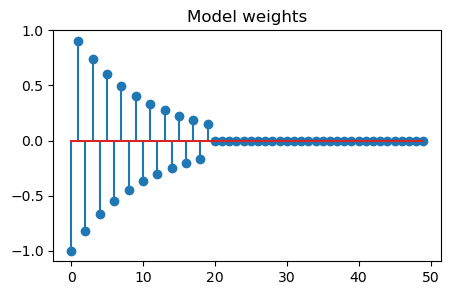

In [13]:
## Simulation setting
n_features = 50
nnz = 20
idx = np.arange(n_features)
w0 = (-1) ** (idx + 1) * np.exp(-idx / 10.)
w0[nnz:] = 0.

plt.figure(figsize=(5, 3))
plt.stem(w0)
plt.title("Model weights")

from scipy.optimize import check_grad


X, y = simu_logreg(w0, corr=0.6)
model = ModelLogReg(X, y, strength=1e-3)
w = np.random.randn(n_features)
send('Checkgrad returns %.2e' % (check_grad(model.loss, model.grad, w)), 11)
print('Checkgrad returns %.2e' % (check_grad(model.loss, model.grad, w))) # This must be a number (of order 1e-6)


In [14]:
print("lip=", model.lip())
print("lip_max=", model.lip_max())
print("lip_coordinates=", model.lip_coordinates())

lip= 1.0319109181682717
lip_max= 35.83405188269344
lip_coordinates= [0.25 0.24 0.24 0.25 0.25 0.25 0.27 0.25 0.24 0.27 0.24 0.24 0.24 0.26
 0.27 0.26 0.26 0.27 0.24 0.24 0.25 0.23 0.21 0.23 0.25 0.25 0.24 0.25
 0.26 0.25 0.26 0.26 0.25 0.24 0.25 0.26 0.25 0.23 0.26 0.24 0.24 0.24
 0.25 0.25 0.25 0.26 0.24 0.24 0.23 0.25]


<a id='solvers'></a>
## 3. Solvers

We now have classes `ModelLinReg` and `ModelLogReg` that allow to compute $f(w)$, $\nabla f(w)$, 
$\nabla f_i(w)$ and $\frac{\partial f(w)}{\partial w_j}$ for the objective $f$
given by linear and logistic regression. We want now to code and compare several solvers to minimize $f$.

In [15]:
def true_parameters(n_features):    
    nnz = 20 # Number of non-zeros coordinates.
    idx = np.arange(n_features)
    w = (-1) ** (idx + 1) * np.exp(-idx / 10.)
    w[nnz:] = 0.
    return w

# Number of features
n_features = 50

# Starting point of all solvers
w0 = np.zeros(n_features)

# Number of iterations
n_iter = 200

# True parameter used to generate data for both logistic/linear regression
W_TRUE = true_parameters(n_features)

In [16]:
# Choose which kind of regression to do.

TYPE_REGRESSION = "Linear" # or "Logistic"


if TYPE_REGRESSION == "Linear":
    X, y = simu_linreg(W_TRUE, corr=0.6)
    model = ModelLinReg(X, y, strength=1e-3)
elif TYPE_REGRESSION == "Logistic":
    X, y = simu_logreg(W_TRUE, corr=0.6)
    model = ModelLogReg(X, y, strength=1e-3)
else:
    raise ValueError("The type of regression is incorrect. Must be 'Linear' or 'Logistic'.")
    

In [17]:
from scipy.optimize import check_grad


send(float(check_grad(model.loss, model.grad, w0)), 12)
print(check_grad(model.loss, model.grad, w0)) # This must be a number (of order 1e-6)

7.816310226931597e-08


<a id='tools'></a>
## 3.1 Tools for the solvers

The following tools store the loss after each epoch

In [18]:
def inspector(model, n_iter, verbose=True):
    """A closure called to update metrics after each iteration.
    Don't even look at it, we'll just use it in the solvers."""
    objectives = []
    it = [0] # This is a hack to be able to modify 'it' inside the closure.
    def inspector_cl(w):
        obj = model.loss(w)
        objectives.append(obj)
        if verbose == True:
            if it[0] == 0:
                print(' | '.join([name.center(8) for name in ["it", "obj"]]))
            if it[0] % (n_iter / 5) == 0:
                print(' | '.join([("%d" % it[0]).rjust(8), ("%.6e" % obj).rjust(8)]))
            it[0] += 1
    inspector_cl.objectives = objectives
    return inspector_cl

<a id='gd'></a>
## 3.2 Gradient descent

We start by implementing the simple gradient descent. We will use it to compute the optimal point $w_\star$. 
Next, we will plot for each algorithm the excess loss $f(w) - f(w_\star)$ to check its rate of convergence.

**4) Complete the function `gd` below that implements the gradient descent algorithm and test it using the next cell.**




In [19]:
def gd(model, w0, step,  n_iter, callback, verbose=True):
    """Gradient descent
    """
    #step = 1 / model.lip()
    w = w0.copy()
    w_new = w0.copy()
    if verbose:
        print("Lauching GD solver...")
    callback(w)
    for k in range(n_iter + 1):
        ################## TODO BLOCK
        w_new[:] = w - step * model.grad(w)
        w[:] = w_new # Remark : does operation inplace
        ################## END TODO BLOCK
        callback(w)
    return w
send(gd, 14)

<Response [400]>

Now we compute the optimal loss $f_\star \triangleq f(w_\star)$.

In [20]:
callback_long = inspector(model, n_iter=10000, verbose=False)
w_star = gd(model, w0, step=1/model.lip(), n_iter=10000, callback=callback_long, verbose=False)
obj_min = callback_long.objectives[-1]

The excess loss will be plotted using the below function.

In [21]:
def plot_callbacks(callbacks, names, obj_min, title):

    plt.figure(figsize=(6, 6))
    plt.yscale("log")

    for callback, name in zip(callbacks, names):
        objectives = np.array(callback.objectives)
        objectives_dist = objectives - obj_min    
        plt.plot(objectives_dist, label=name, lw=2)

    plt.tight_layout()
    plt.xlim((0, len(objectives_dist)))
    plt.xlabel("Number of passes on the data", fontsize=16)
    plt.ylabel(r"$f(w_k) - f_\star$", fontsize=16)
    plt.legend(loc='lower left')
    plt.title(title, fontsize=16)
    plt.tight_layout()
    return plt

In [22]:
n_iter=50

In [23]:
callback_gd = inspector(model, n_iter=n_iter)
w_gd = gd(model, w0, step= 1/model.lip(),  n_iter=n_iter, callback=callback_gd)

Lauching GD solver...
   it    |   obj   
       0 | 9.457289e-01
      10 | 3.083973e-01
      20 | 1.753318e-01
      30 | 1.396779e-01
      40 | 1.295085e-01
      50 | 1.264974e-01


<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

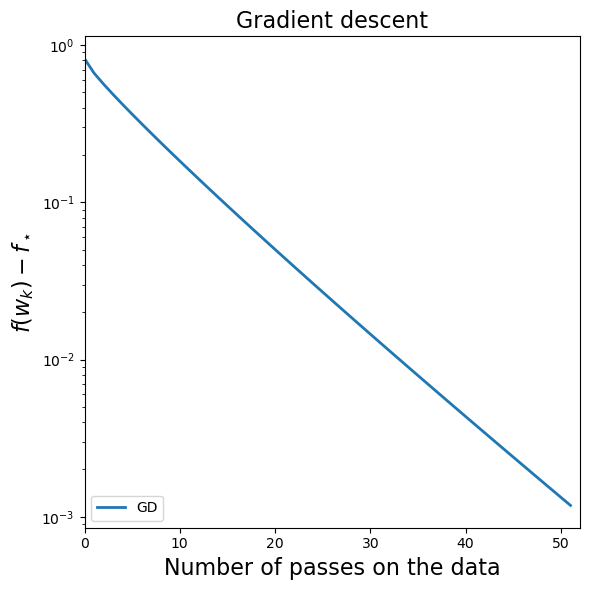

In [24]:
plot_callbacks([callback_gd], ["GD"], obj_min, "Gradient descent")

**5) Which step size did you choose? What is the expected rate of convergence?**

################## TODO BLOCK

Using $\gamma = 1/L$, we expect a linear convergence rate as we have the following bound:
$$
\forall k \in \mathbb N, f(w_k) - f_\star \leq \left(1 - \frac{\mu}{L} \right)^{2k} (f(w_0) - f_\star)
$$

################## END TODO BLOCK


<a id='sgd'></a>
## 3.3 Stochastic gradient descent

**6) Complete the function `sgd` below that implements the stochastic gradient descent algorithm and test it using the next cell. Implement the Polyak-Ruppert averaging using an online update**

You can implement different strategy for the step size:
- Constant step-size: use $$\gamma = \frac{1}{2L}~.$$
- Decaying step size: use $$ \forall k \in \mathbb N, \gamma_k = \frac{1}{L\sqrt{k + 1}}~.$$

In [25]:
def sgd(model, w0, n_iter, step, callback, stepsize_strategy="constant",
        pr_averaging=False, verbose=True):
    
    """Stochastic gradient descent.
    
    stepsize_strategy:{"constant", "strongly_convex", "decaying"}
        define your own strategies to update (or not) the step size.
    pr_averaging: True if using polyak-ruppert averaging.
    """
    
    mu = model.strength
    w = w0.copy()
    w_averaged = w0.copy()
    callback(w)
    n_samples = model.n_samples
    L = model.lip_max()
    it = 0
    for idx in range(n_iter):
        
        idx_samples = np.random.randint(0, model.n_samples, model.n_samples)
        for i in idx_samples: 
            if stepsize_strategy == "constant":
                stepsize = step / (2*L)     ####### TODO OPERAND
            elif stepsize_strategy == "strongly_convex":
                # For strongly-convex (choice in the slides)
                stepsize = step / max(mu*(it + 1), L)      ####### TODO OPERAND
            elif stepsize_strategy == "decaying":
                stepsize = step / (L * np.sqrt(it + 1))     ####### TODO OPERAND
            else:
                raise ValueError('The momentum strategy is not correct')

            w -= stepsize * model.grad_i(i, w)      ####### TODO OPERAND

            if pr_averaging:
                # Polyak-Ruppert averaging
                w_averaged = it/(it+1)*w_averaged + 1/(it+1)*w      ####### TODO OPERAND
            it += 1


        if pr_averaging:
            callback(w_averaged)
        else:
            callback(w) 
    if pr_averaging:
        return w_averaged
    return w


send(sgd, 15)

<Response [400]>

In [26]:
step = 1

callback_sgd_constant = inspector(model, n_iter=n_iter)
callback_sgd_decaying = inspector(model, n_iter=n_iter)
callback_sgd_constant_PR = inspector(model, n_iter=n_iter)
callback_sgd_decaying_PR = inspector(model, n_iter=n_iter)

sgd(model, w0, n_iter=n_iter, step=step, callback=callback_sgd_constant, 
    stepsize_strategy="constant")
sgd(model, w0, n_iter=n_iter, step=step, callback=callback_sgd_decaying, 
    stepsize_strategy="decaying")
sgd(model, w0, n_iter=n_iter, step=step, callback=callback_sgd_constant_PR, 
    stepsize_strategy="constant", pr_averaging=True)
sgd(model, w0, n_iter=n_iter, step=step, callback=callback_sgd_decaying_PR, 
    stepsize_strategy="decaying", pr_averaging=True)

   it    |   obj   
       0 | 9.457289e-01
      10 | 1.357491e-01
      20 | 1.303999e-01
      30 | 1.355942e-01
      40 | 1.409257e-01
      50 | 1.382919e-01
   it    |   obj   
       0 | 9.457289e-01
      10 | 4.462341e-01
      20 | 3.542346e-01
      30 | 3.029583e-01
      40 | 2.690219e-01
      50 | 2.449658e-01
   it    |   obj   
       0 | 9.457289e-01
      10 | 1.324749e-01
      20 | 1.272041e-01
      30 | 1.261781e-01
      40 | 1.257281e-01
      50 | 1.255563e-01
   it    |   obj   
       0 | 9.457289e-01
      10 | 5.302046e-01
      20 | 4.475884e-01
      30 | 3.982925e-01
      40 | 3.635404e-01
      50 | 3.370997e-01


array([-0.58,  0.35, -0.37,  0.34, -0.29,  0.27, -0.26,  0.19, -0.17,
        0.22, -0.21,  0.12, -0.13,  0.13, -0.09,  0.08, -0.11,  0.12,
       -0.08,  0.11,  0.01, -0.02,  0.01, -0.02,  0.05, -0.02, -0.07,
        0.03, -0.05, -0.01, -0.02,  0.06, -0.02,  0.01,  0.03, -0.04,
       -0.03,  0.02,  0.02, -0.02, -0.03,  0.02,  0.01,  0.01,  0.02,
        0.02, -0.04, -0.04,  0.01,  0.02])

<Response [400]>

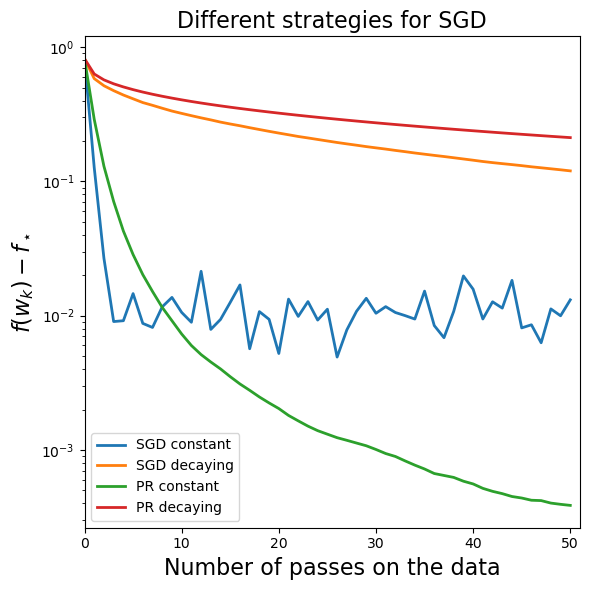

In [27]:
callbacks_sgd = [callback_sgd_constant, callback_sgd_decaying, callback_sgd_constant_PR, callback_sgd_decaying_PR]

names_sgd = ["SGD constant", "SGD decaying", "PR constant", "PR decaying"]

send(plot_callbacks(callbacks_sgd, names_sgd, obj_min, "Different strategies for SGD"), 16)

<a id='agd'></a>
## 3.4 Accelerated gradient descent

**7) Complete the function `agd` below that implements the (Nesterov) accelerated gradient descent algorithm and test it using the next cell.**

What choice of momentum coefficient is recommended for AGD ?
- for strongly convex
- for convex functions

Here you can implement different strategy:
- Constant: use an arbitrary value (e.g. 0.9).
- Using the strong convexity (see https://blogs.princeton.edu/imabandit/2014/03/06/nesterovs-accelerated-gradient-descent-for-smooth-and-strongly-convex-optimization/):
$$\beta = \frac{\sqrt{\kappa} - 1}{
\sqrt{\kappa} + 1}, \quad \text{with} \quad \kappa = \frac{L}{\mu}.$$
- Using only convexity (see https://blogs.princeton.edu/imabandit/2018/11/21/a-short-proof-for-nesterovs-momentum/)
$$ \beta_k = \frac{t_{k-1} -1}{t_k}, \quad \text{with} \quad t_k = \frac{1}{2} (1 + \sqrt{1 + 4 t_{k-1}^2}). $$ 
This value can be approximated by $$\beta_k = \frac{k}{k+3}.$$

In [28]:
def agd(model, w0, n_iter, callback, verbose=True, momentum_strategy="constant"):
    """(Nesterov) Accelerated gradient descent.
    
    momentum_strategy: {"constant","convex","convex_approx","strongly_convex"} 
        define your own strategies to update (or not) the momentum coefficient.
    """
    mu = model.strength
    step = 1 / model.lip()
    w = w0.copy()
    w_new = w0.copy()
    # An extra variable is required for acceleration
    z = w0.copy() # the auxiliari point at which the gradient is taken
    t = 1. # beta this morning = momentum coefficient 
    t_new = 1.    
    if verbose:
        print("Lauching AGD solver...")
    callback(w)
    for k in range(n_iter + 1):
        
        ################## TODO BLOCK
        w_new[:] = z - step * model.grad(z)
        
        if momentum_strategy == "constant":
            beta = 0.9      
        elif momentum_strategy == "convex":
            # See https://blogs.princeton.edu/imabandit/2018/11/21/a-short-proof-for-nesterovs-momentum/
            # Optimal momentum coefficinet for smooth convex
            t_new = (1. + sqrt(1. + 4. * t * t)) / 2. 
            beta = (t - 1) / t_new      
        elif momentum_strategy == "convex_approx":
            beta = k/(k+3) 
        elif momentum_strategy == "strongly_convex":
            # See https://blogs.princeton.edu/imabandit/2014/03/06/nesterovs-accelerated-gradient-descent-for-smooth-and-strongly-convex-optimization/
            if mu>0:
                kappa = (model.lip())/(mu) 
                beta = (sqrt(kappa) - 1)/(sqrt(kappa) + 1) # For strongly convex
            else:
                beta = k/(k+3)   
        else:
            raise ValueError('The momentum strategy is not correct')

        z[:] = w_new + beta * (w_new - w)  
        t = t_new  
        w[:] = w_new   
        ################## END TODO BLOCK      
        callback(w)
    return w

send(agd, 17)

<Response [400]>

In [29]:
callback_agd_constant = inspector(model, n_iter=n_iter)
callback_agd_convex = inspector(model, n_iter=n_iter)
callback_agd_convex_approx = inspector(model, n_iter=n_iter)
callback_agd_strongly_convex = inspector(model, n_iter=n_iter)

agd(model, w0, n_iter=n_iter, callback=callback_agd_constant, momentum_strategy="constant")
agd(model, w0, n_iter=n_iter, callback=callback_agd_convex, momentum_strategy="convex")
agd(model, w0, n_iter=n_iter, callback=callback_agd_convex_approx, momentum_strategy="convex_approx")
agd(model, w0, n_iter=n_iter, callback=callback_agd_strongly_convex, momentum_strategy="strongly_convex")

Lauching AGD solver...
   it    |   obj   
       0 | 9.457289e-01
      10 | 1.854096e-01
      20 | 1.292826e-01
      30 | 1.275975e-01
      40 | 1.257221e-01
      50 | 1.252190e-01
Lauching AGD solver...
   it    |   obj   
       0 | 9.457289e-01
      10 | 1.589609e-01
      20 | 1.282101e-01
      30 | 1.253738e-01
      40 | 1.252091e-01
      50 | 1.251988e-01
Lauching AGD solver...
   it    |   obj   
       0 | 9.457289e-01
      10 | 1.652690e-01
      20 | 1.277508e-01
      30 | 1.253060e-01
      40 | 1.252106e-01
      50 | 1.251958e-01
Lauching AGD solver...
   it    |   obj   
       0 | 9.457289e-01
      10 | 2.905802e-01
      20 | 1.439058e-01
      30 | 1.402688e-01
      40 | 1.359667e-01
      50 | 1.281806e-01


array([-0.96,  0.85, -0.76,  0.72, -0.63,  0.57, -0.54,  0.47, -0.4 ,
        0.4 , -0.39,  0.3 , -0.28,  0.26, -0.2 ,  0.21, -0.21,  0.17,
       -0.16,  0.17, -0.03,  0.01,  0.03, -0.02,  0.04, -0.03, -0.05,
        0.05, -0.02, -0.02,  0.01,  0.  , -0.03,  0.01,  0.04, -0.04,
        0.01,  0.03, -0.02, -0.  , -0.02,  0.01, -0.01,  0.04,  0.  ,
       -0.02, -0.01, -0.  , -0.01,  0.01])

<Response [400]>

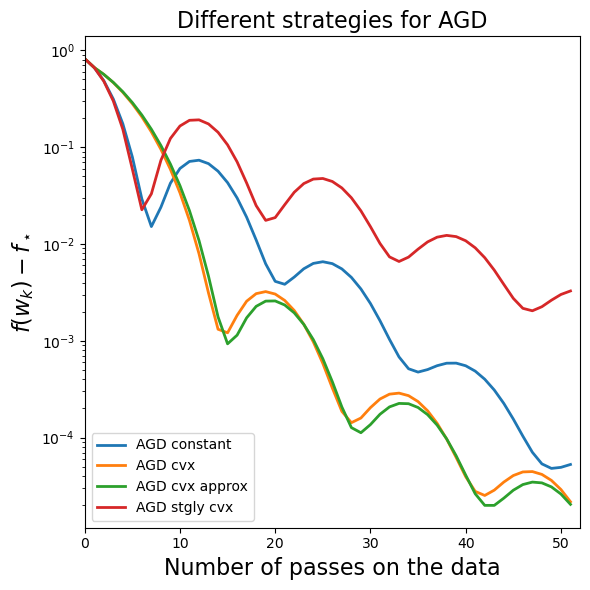

In [30]:
callbacks_agd = [callback_agd_constant, callback_agd_convex, callback_agd_convex_approx, 
                 callback_agd_strongly_convex]
names_agd = ["AGD constant", "AGD cvx", "AGD cvx approx", "AGD stgly cvx"]

send(plot_callbacks(callbacks_agd, names_agd, obj_min, "Different strategies for AGD"), 18)

<a id='hb'></a>
## 3.5. Heavy ball method

**8) Complete the function `hb` below that implements the Heavy ball (HB) method and test it using the next cell.**

In [31]:
def heavy_ball(model, w0, n_iter, step, momentum, callback, verbose=True):
    
    w = w0.copy()
    w_previous = w0.copy()
    callback(w)
    
    for idx in range(n_iter):
        
        ###################### TODO BLOCK
        
        w_next = w - step * model.grad(w) + momentum * (w - w_previous)
        w_previous = w
        w = w_next
        
        ###################### END TOD BLOCK
        
        callback(w)
    
    return w

send(heavy_ball, 19)

<Response [400]>

On strongly convex smooth quadratic functions, the recommended momentum coefficient for Heavy-Ball is
$$
\beta = \left(\frac{\sqrt{\kappa} - 1}{\sqrt{\kappa} + 1}\right)^2, \quad \text{with} \quad \kappa = \frac{L}{\mu}.
$$

and

$$
\gamma = \frac{2}{L+\mu}(1 + \beta) = \frac{4}{(\sqrt{L} + \sqrt{\mu})^2} \,.
$$

This algorithm is guarantee to verify:

$$
\|w_n - w_\star\|^2 \leq \left(\frac{\sqrt{\kappa} - 1}{\sqrt{\kappa} + 1}\right)^{2n} \|w_0 - w_\star\|^2
$$

on quadratic functions.

There exists a famous strongly convex smooth function (not quadratic) which Heavy-Ball with the above setting doesn't converge (See [Lessard et al. (2014)](https://arxiv.org/pdf/1408.3595.pdf) Section 4.6, Equation 4.11 and Figure 7).
[Ghadimi et al. (2014)](https://arxiv.org/pdf/1412.7457.pdf) (Theorem 4) provides a convergence rate on general strongly convex smooth functions that is much worse (not accelerated) than NAG. However, HB works pretty well in pratice and is the default momentum implementation in most DL frammeworks.

Below, the function `hb_optimized` implements the Heavy ball method with optimized tunning (for quadratic functions), test it using the next cells.

In [32]:
def heavy_ball_optimized(model, w0, n_iter, callback, verbose=True):
        
    mu = model.strength    
    L = model.lip()
    
    gamma = 3.99 / (sqrt(L) + sqrt(mu))**2
    beta = ((sqrt(L) - sqrt(mu)) / (sqrt(L) + sqrt(mu)))**2
    
    print(gamma, beta)
    
    return heavy_ball(model=model,
              w0=w0,
              n_iter=n_iter,
              step=gamma,
              momentum=beta,
              callback=callback,
              verbose=verbose,
             )

send(heavy_ball_optimized, 20)

<Response [400]>

In [33]:
callback_hb = inspector(model, n_iter=n_iter)

heavy_ball_optimized(model, w0, n_iter=n_iter, callback=callback_hb)

0.9318787310656852 0.9398043764873789
   it    |   obj   
       0 | 9.457289e-01
      10 | 4.464862e-01
      20 | 3.682015e-01
      30 | 2.004223e-01
      40 | 1.933943e-01
      50 | 1.535838e-01


array([-1.02,  0.9 , -0.77,  0.78, -0.65,  0.56, -0.49,  0.44, -0.49,
        0.43, -0.39,  0.28, -0.27,  0.27, -0.18,  0.16, -0.16,  0.15,
       -0.15,  0.17, -0.04,  0.02,  0.03, -0.06,  0.09, -0.07, -0.09,
        0.05, -0.02, -0.06,  0.01, -0.08,  0.02,  0.01, -0.04, -0.1 ,
        0.05, -0.02, -0.05, -0.02, -0.05, -0.01,  0.01,  0.04, -0.01,
       -0.05, -0.02,  0.07, -0.06,  0.02])

<Response [400]>

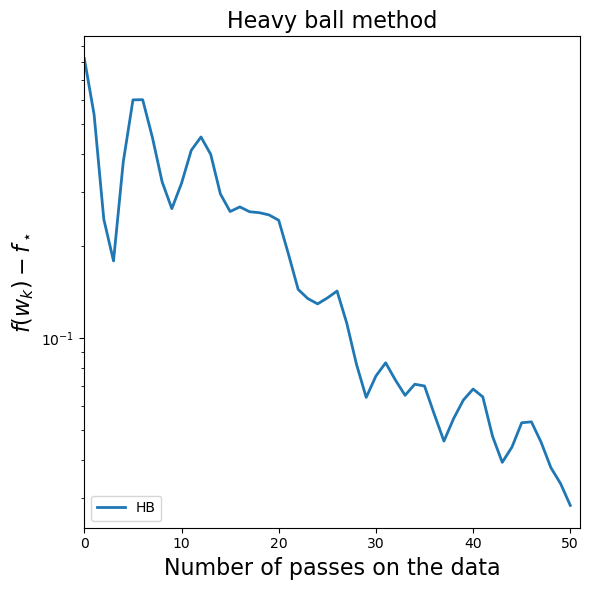

In [34]:
send(plot_callbacks([callback_hb], ["HB"], obj_min, "Heavy ball method"), 21)

<a id='sag'></a>
## 3.6. Stochastic average gradient descent

**9) Complete the function `sag` below that implements the stochastic averaged gradient algorithm and test it using the next cell.**

In [35]:
def sag(model, w0, n_iter, step, callback, verbose=True):
    """Stochastic average gradient descent
    """
    w = w0.copy()
    n_samples, n_features = model.n_samples, model.n_features
    gradient_memory = np.zeros((n_samples, n_features)) # one gradient per sample n= 60k,  d= 50M  => 3 10^12
    y = np.zeros(n_features)
    callback(w)
    it = 0
    for idx in range(n_iter):
        
        ################## TODO BLOCK
        idx_samples = np.random.randint(0, model.n_samples, model.n_samples)
        for i in idx_samples:      
            y_new = model.grad_i(i, w)
            y += (y_new - gradient_memory[i]) / n_samples
            gradient_memory[i] = y_new
            w -= step * y
        ################## END TODO BLOCK    
        
        callback(w)
    return w

send(sag, 22)

<Response [400]>

In [36]:
step = 1 / model.lip_max()
callback_sag = inspector(model, n_iter=n_iter)
w_sag = sag(model, w0, n_iter=n_iter, step=step, callback=callback_sag)

   it    |   obj   
       0 | 9.457289e-01
      10 | 1.280555e-01
      20 | 1.251965e-01
      30 | 1.251703e-01
      40 | 1.251697e-01
      50 | 1.251697e-01


**10) What is the rate of convergence of SAG? What is the main problem of this algorithm? What is its memory footprint?**

################## TODO BLOCK  

SAG is a linear convergent algorithm. Its rate of convergence is equivalent to SGD during first iterations, then equivalent to GD. The main drawback of SAG is it's memory cost. It requires to store $n$ gradient, that is to say a matrix of size $n\times d$.

################## END TODO BLOCK  

<a id='svrg'></a>
## 3.7. Stochastic variance reduced gradient

**11) Complete the function `svrg` below that implements the stochastic variance reduced gradient algorithm and test it using the next cell.**

In [37]:
def svrg(model, w0, n_iter, step, callback, verbose=True):
    """Stochastic variance reduced gradient descent
    """
    w = w0.copy()
    w_old = w.copy()
    temp_sum = 0
    n_samples = model.n_samples
    callback(w)
    for idx in range(n_iter):        
        
        ################## TODO BLOCK
        w_old[:] = temp_sum/n_samples
        mu = model.grad(w)
        temp_sum = 0
        idx_samples = np.random.randint(0, model.n_samples, model.n_samples)
        for i in idx_samples:  
            z_new = model.grad_i(i, w)
            z_old = model.grad_i(i, w_old)  ### w_old is the only thing I keep, I can recompute the gradient f_i (w_old)
            ## SVRG trades memory for computation
            w -= step * (z_new - z_old + mu)
            temp_sum += w
        ################## END TODO BLOCK    
        
        callback(w)
    return 
send(svrg, 23)

<Response [400]>

In [38]:
step = 1 / model.lip_max()
callback_svrg = inspector(model, n_iter=n_iter)
w_svrg = svrg(model, w0, n_iter=n_iter,
              step=step, callback=callback_svrg)

   it    |   obj   
       0 | 9.457289e-01
      10 | 1.275525e-01
      20 | 1.251847e-01
      30 | 1.251698e-01
      40 | 1.251697e-01
      50 | 1.251697e-01


<Response [400]>

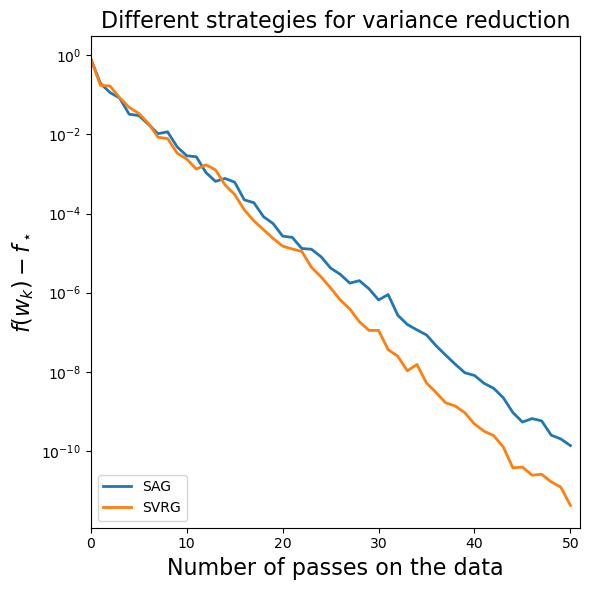

In [39]:
callbacks_variance_reduction = [callback_sag, callback_svrg]
names_variance_reduction = ["SAG", "SVRG"]

send(plot_callbacks(callbacks_variance_reduction, names_variance_reduction, obj_min, "Different strategies for variance reduction"), 24)

<a id='newton'></a>


## 3.8 Newton descent

Newton algorithm consist in optimizing the exact taylor approximation of the function at order 2 of the function. To compare it with first order methods, we propose to implement it here. The actualization writes 

$$
w^{t+1} = w^t - \gamma [\nabla^2f(w^t)]^{-1}\nabla f(w^t).
$$


**12) Complete the function `newton` that implements the newton solver and test it.**

In [40]:
def newton(model, w0, n_iter, step, callback, verbose=True):
    """Newton"""
    w = w0.copy()
    n_features = model.n_features
    accumulated_gradient = np.zeros(n_features)
    u =  np.zeros(n_features)
    if verbose:
        print("Lauching Newton solver...")
    callback(w)
    for k in range(n_iter + 1):
        ################## TODO BLOCK
        gradient = model.grad(w)
        hessian = model.hessian()
        direction = np.linalg.inv(hessian).dot(gradient)
        w  -= step * direction
        ################## END TODO BLOCK
        callback(w)
    return w

send(newton, 25)

<Response [400]>

In [41]:
step = 0.1
callback_newton = inspector(model, n_iter=n_iter)
w_newton = newton(model, w0, n_iter=n_iter, step = step, callback=callback_newton)

Lauching Newton solver...
   it    |   obj   
       0 | 9.457289e-01
      10 | 2.249305e-01
      20 | 1.372982e-01
      30 | 1.266442e-01
      40 | 1.253489e-01
      50 | 1.251915e-01


<Response [400]>

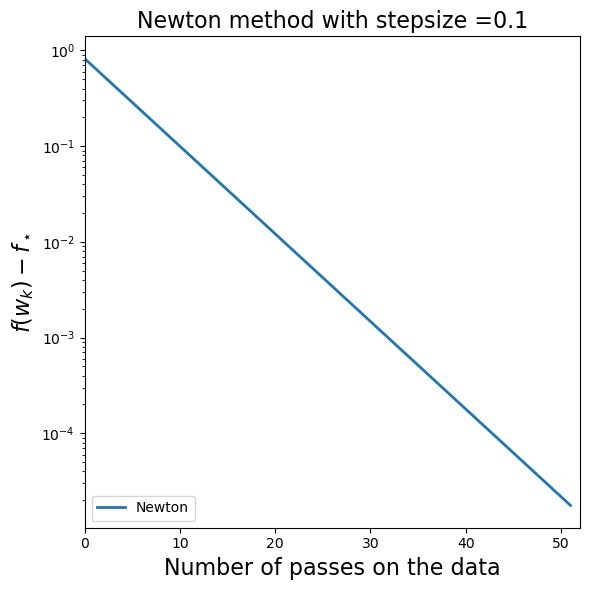

In [42]:
callbacks_newton = [callback_newton]
names_newton = ["Newton"]

send(plot_callbacks(callbacks_newton, names_newton, obj_min, f"Newton method with stepsize ={step}"), 26)

<a id='cgd'></a>

## 3.9 Coordinate gradient descent

CGD is considered as the best optimization algorithm. It writes at step $t$

For $k$ in $ 0,\ldots, d$ do:
$
w^{t+1}_k = w^t_k - \gamma_k \partial_{w_k} f(w^t)
$

**13) Complete the function `cgd` below that implements the coordinate gradient descent algorithm and test it using the next cell.**

In [43]:
def cgd(model, w0, n_iter, callback, verbose=True):
    """Coordinate gradient descent
    """
    w = w0.copy()
    n_features = model.n_features
    steps = 1 / model.lip_coordinates()
    if verbose:
        print("Lauching CGD solver...")
    callback(w)
    for k in range(n_iter + 1):
        ################## TODO BLOCK
        for j in range(n_features): # 50 features
            w[j] -= steps[j] * model.grad_coordinate(j, w)  # 
        ################## END TODO BLOCK
        callback(w)
    return w
send(cgd, 13)

<Response [400]>

In [44]:
callback_cgd = inspector(model, n_iter=n_iter)
w_cgd = cgd(model, w0, n_iter=n_iter, callback=callback_cgd)

Lauching CGD solver...
   it    |   obj   
       0 | 9.457289e-01
      10 | 1.251940e-01
      20 | 1.251697e-01
      30 | 1.251697e-01
      40 | 1.251697e-01
      50 | 1.251697e-01


Now we compute the optimal loss $f_\star \triangleq f(w_\star)$.

In [45]:
callback_long = inspector(model, n_iter=1000, verbose=False)
w_cgd = cgd(model, w0, n_iter=1000, callback=callback_long, verbose=False)
obj_min = callback_long.objectives[-1]

The excess loss will be plotted using the below function.

In [46]:
def plot_callbacks(callbacks, names, obj_min, title):

    plt.figure(figsize=(6, 6))
    plt.yscale("log")

    for callback, name in zip(callbacks, names):
        objectives = np.array(callback.objectives)
        objectives_dist = objectives - obj_min    
        plt.plot(objectives_dist, label=name, lw=2)

    plt.tight_layout()
    plt.xlim((0, len(objectives_dist)))
    plt.xlabel("Number of passes on the data", fontsize=16)
    plt.ylabel(r"$f(w_k) - f_\star$", fontsize=16)
    plt.legend(loc='lower left')
    plt.title(title, fontsize=16)
    plt.tight_layout()
    return plt

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

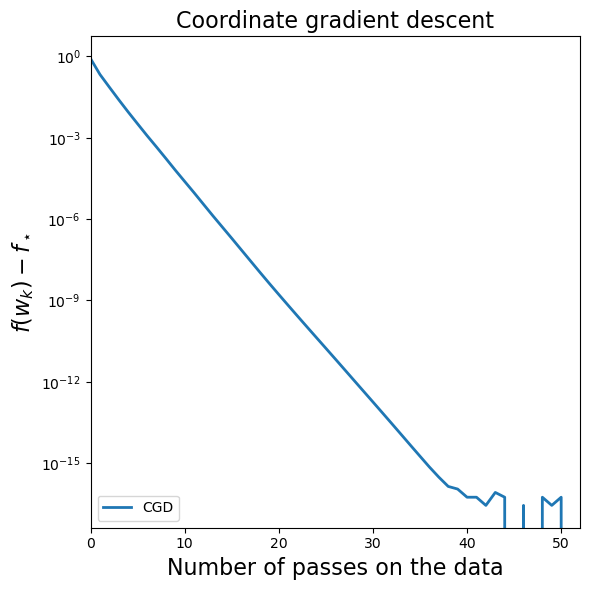

In [47]:
plot_callbacks([callback_cgd], ["CGD"], obj_min, "Coordinate gradient descent")

<a id='comparison'></a>
# 3.10 Comparison of all previous algorithms

**14) Plot the values of the loss for the different iteration and for each solver. Comment.**

<Response [400]>

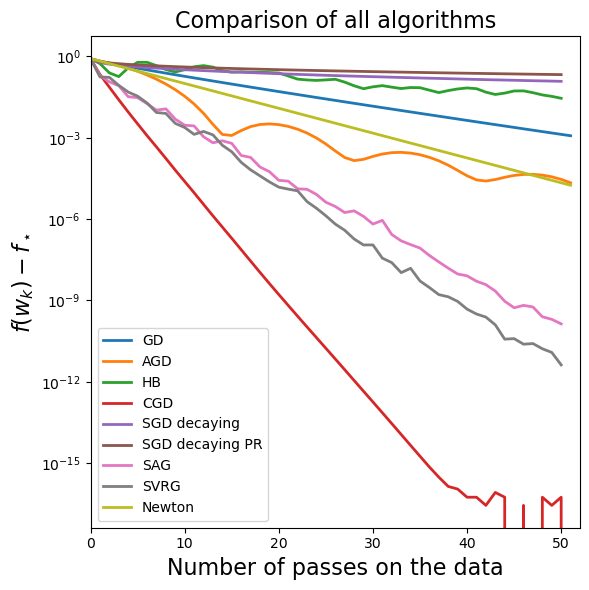

In [48]:
callbacks = [callback_gd, callback_agd_convex, callback_hb, callback_cgd, 
             callback_sgd_decaying, callback_sgd_decaying_PR,
             callback_sag, callback_svrg,
             callback_newton]
names = ["GD", "AGD", "HB", "CGD", 
         "SGD decaying", "SGD decaying PR",
         "SAG", "SVRG",
         "Newton"]

send(plot_callbacks(callbacks, names, obj_min, "Comparison of all algorithms"), 27)

In [49]:
callback_long = inspector(model, n_iter=1000, verbose=False)
w_cgd = cgd(model, w0, n_iter=1000, callback=callback_long, verbose=False)
obj_min = callback_long.objectives[-1]

Use this function to answer the 2 following questions

In [50]:
def gd_perf_on_log_reg_wrt_correlation_and_regularization(corr=.6, strength=1e-3):
    X_loc, y_loc = simu_logreg(w0, corr=corr)
    model_loc = ModelLogReg(X_loc, y_loc, strength=strength)
    
    callback_long = inspector(model_loc, n_iter=1000, verbose=False)
    w_long = gd(model_loc, w0, step= 1/model_loc.lip(),  n_iter=1000, callback=callback_long, verbose=False)

    callback_loc = inspector(model_loc, n_iter=n_iter, verbose=False)
    w_loc = gd(model_loc, w0, step= 1/model_loc.lip(),  n_iter=n_iter, callback=callback_loc, verbose=False)
    
    return ((model_loc.loss(w_loc) - model_loc.loss(w_long)) / (model_loc.loss(w0) - model_loc.loss(w_long)))**(1/n_iter)

**15) In logistic regression, study the influence of the correlation of the features on the performance of the optimization algorithms. Explain.**

<Response [400]>

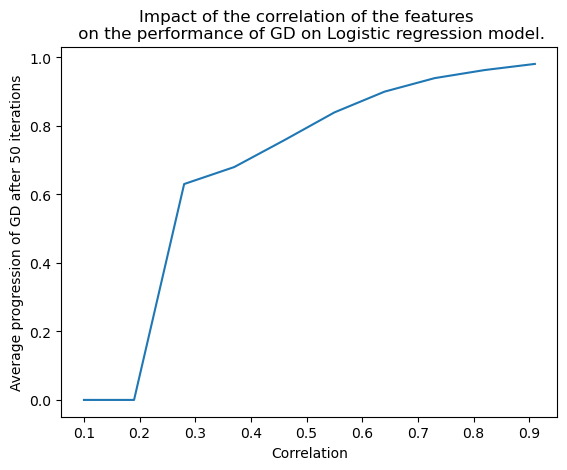

In [51]:
corrs = np.linspace(.1, 1, 10, endpoint=False)
gd_final_values = list()

## TODO BLOCK

for corr in corrs:
    gd_final_values.append(gd_perf_on_log_reg_wrt_correlation_and_regularization(corr=corr))
    
# END TODO BLOCK

plt.plot(corrs, gd_final_values)
plt.xlabel("Correlation")
plt.ylabel("Average progression of GD after 50 iterations")
plt.title("Impact of the correlation of the features \n on the performance of GD on Logistic regression model.")
send(plt, 28)


########### TODO BLOCK

The greater the correlation between features is, the flatter the hessian of the model is.
And, since first order optimization methods performances depend on the condition number of the model, a flatter hessian slows down the optimization.
Hence, a bigger correlation leads to slower convergence of the optimization method.

########### END TODO BLOCK


**16) In logistic regression, study the influence of the level of ridge penalization on the performance of the optimization algorithms. Explain.**

<Response [400]>

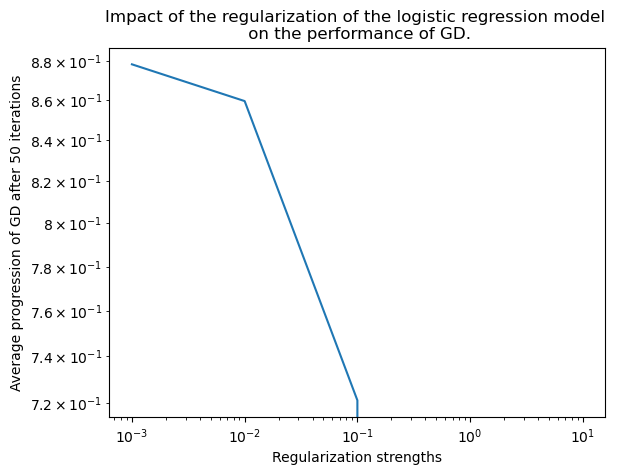

In [52]:
strengths = np.logspace(-3, 1, 5)
gd_final_values = list()

## TODO BLOCK

for strength in strengths:
    gd_final_values.append(gd_perf_on_log_reg_wrt_correlation_and_regularization(strength=strength))
    
# END TODO BLOCK

plt.plot(strengths, gd_final_values)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Regularization strengths")
plt.ylabel("Average progression of GD after 50 iterations")
plt.title("Impact of the regularization of the logistic regression model \n on the performance of GD.")
send(plt, 29)

########### TODO BLOCK

The stronger the regularization is, the smaller the condition number of the model is. Indeed the condition number is of the form $\frac{\lambda}{\lambda + L_0}$ where $L_0$ is the smoothness paramter without regularization.
Then, increasing the regularization helps the optimization algorithms to perform well.

########### END TODO BLOCK